# Grover's algorithm


*Estimated QPU usage: 4 seconds (tested on IBM Nairobi)*

## Background

Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the `GroverOperator` from the Qiskit circuit library to easily set up a Grover's search instance. The runtime `Sampler` primitive allows seamless execution of Grover circuits.


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later


## Step 1. Map classical inputs to a quantum problem

Grover's algorithm requires an [oracle](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm) that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.  A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^{N}-1$ state (`'1'`\*$N$ bit-string).  Marking basis states with one or more `'0'` in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit.  In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation.  The `MCMT` gate is used to implement the multi-controlled Z-gate.


### Setup

Here we import the small number of tools we need for this tutorial.


In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")
backend.name

'ibm_brisbane'

In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for one or more marked states."""
    if isinstance(marked_states, str):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits)

    for target in marked_states:
        # Qiskit uses little-endian ordering, so reverse your string
        rev_target = target[::-1]

        # Find qubit indices where the bit is '0'
        zero_inds = [i for i, bit in enumerate(rev_target) if bit == '0']

        # Pre-flip those wires
        for q in zero_inds:
            qc.x(q)

        # Multi-controlled Z across all qubits
        oracle_gate = MCMT(ZGate(), num_qubits - 1, 1)
        qc.compose(oracle_gate, qc.qubits, inplace=True)

        # Un-flip
        for q in zero_inds:
            qc.x(q)

    return qc

### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of Grover search.  In this example we will mark two computational states out of the eight available in a three-qubit computational space:


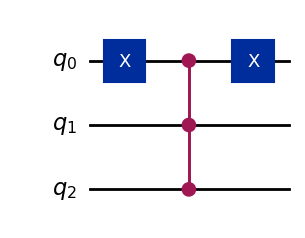

In [4]:
marked_states = ['110']

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator

The built-in Qiskit `GroverOperator` takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle.  Here, we `decompose` the circuit to see the gates within the operator:


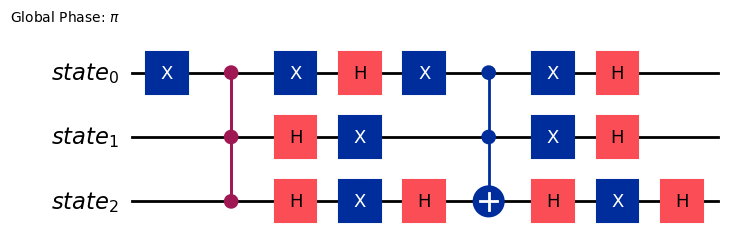

In [5]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit.  There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:


In [6]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (`grover_op`) repeated the optimal number of times.  Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.


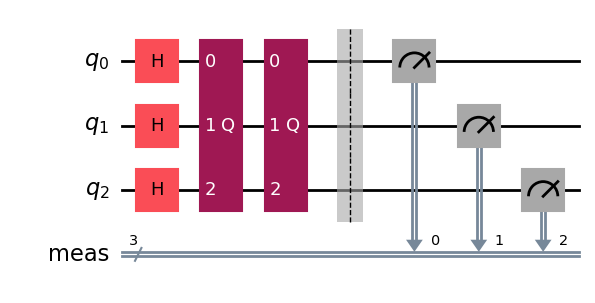

In [7]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2. Optimize problem for quantum execution



=== Marked states: ['110'] ===
Depth:            182
Total ops:        285
Gate counts:      {'rz': 147, 'sx': 91, 'ecr': 39, 'x': 5, 'measure': 3, 'barrier': 1}
Qubits / Clbits:  127 / 3


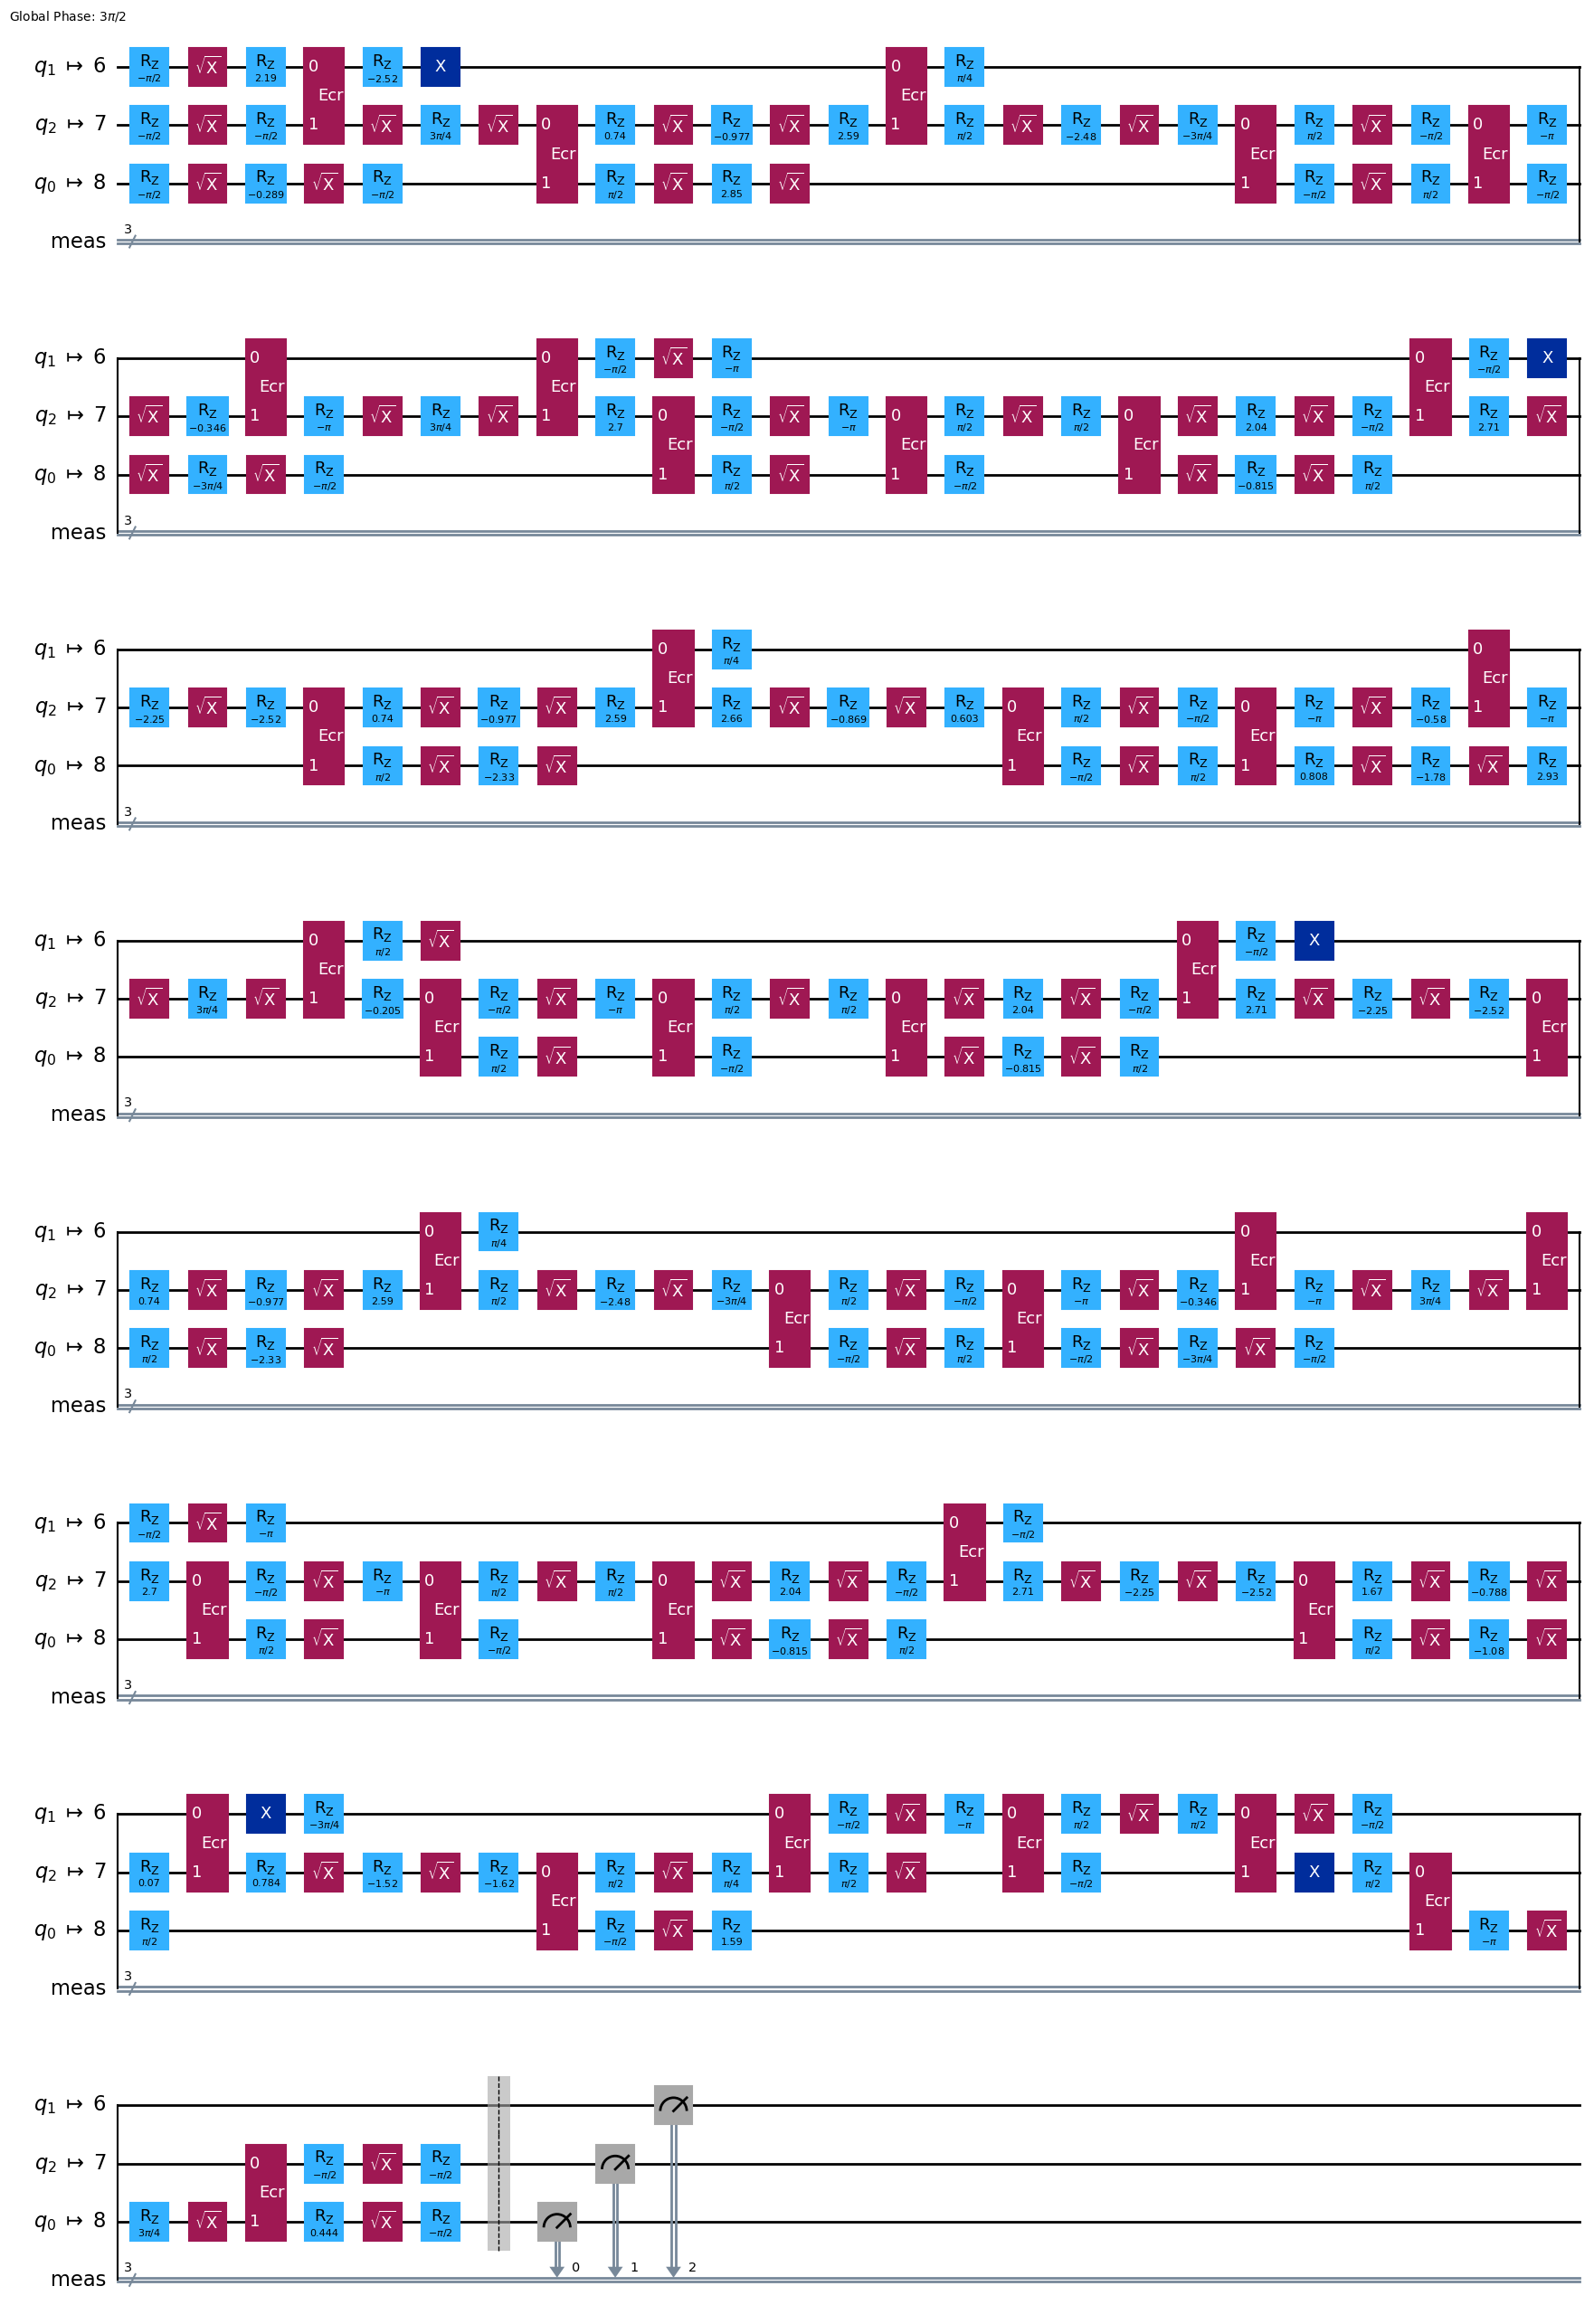

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm     = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)

# either of these two…
print(f"\n=== Marked states: {marked_states} ===")
# or, if you want just the one string:
# print(f"\n=== Marked state: {marked_states[0]} ===")

print("Depth:           ", circuit_isa.depth())
print("Total ops:       ", circuit_isa.size())
print("Gate counts:     ", dict(circuit_isa.count_ops()))
print("Qubits / Clbits: ", circuit_isa.num_qubits, "/", circuit_isa.num_clbits)

circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## Step 3. Execute using Qiskit Primitives

Amplitude amplification is a sampling problem that is suitable for execution with the [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) runtime primitive.

Note that the `run()` method of [Qiskit Runtime `SamplerV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2)  takes an iterable of `primitive unified blocs (PUBs)`. For sampler, each PUB is an iterable in the format `(circuit, parameter_values)`. However, at a minimum, it takes a list of quantum circuit(s).


In [9]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:903: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


## Step 4. Post-process, return result in classical format


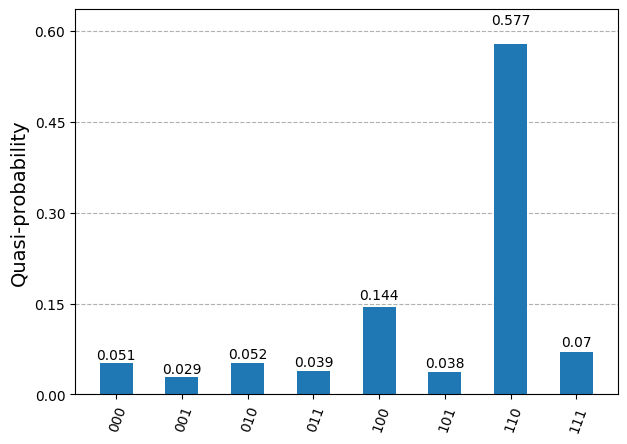

In [10]:
plot_distribution(dist)